<a href="https://colab.research.google.com/github/jecampagne/ML-toys/blob/main/Sampling_simple_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!pip install -q distrax

In [39]:
from functools import partial

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18


import jax
import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian

import distrax

from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels


In [260]:
#avoid boring Warnings
import logging
logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

# Sampling par réjection

In [276]:
base_distribution = distrax.Independent(
        distrax.Normal(loc=0., scale=1.5),
    )

In [278]:
# pdf cible
p1 = 2/0.1 / (8/0.5 + 2/0.1)
p2 = 1.-p1
target_distribution = distrax.Independent(
    distrax.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(
          probs=[p1, p2]),
      components_distribution=tfd.Normal(
        loc=[-0.5, 0.5],       # One for each component.
        scale=[0.5, 0.3]
        )
    ),
)

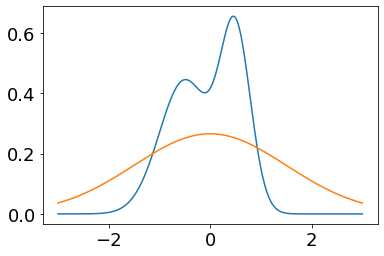

In [280]:
x=jnp.linspace(-3,3,1000)
plt.plot(x,target_distribution.prob(x))
plt.plot(x,base_distribution.prob(x))

In [282]:
# facteur de normalisation
K = 1.1 * jnp.max(jax.numpy.divide(target_distribution.prob(x),base_distribution.prob(x)))

In [315]:
N=300_000

In [316]:
base_spl = base_distribution.sample(seed=jax.random.PRNGKey(10), sample_shape=(N))

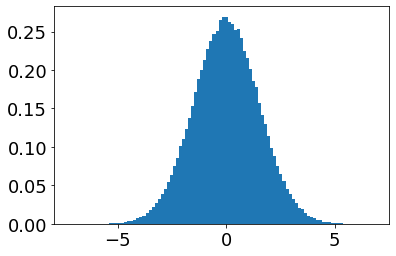

In [317]:
plt.hist(base_spl, bins=100, density=True);

In [318]:
y = jax.numpy.divide(target_distribution.prob(base_spl),base_distribution.prob(base_spl))/K

In [319]:
assert jnp.max(y) <1.0

In [320]:
u = jax.random.uniform(jax.random.PRNGKey(30), shape=(N,))

In [321]:
spl_ok = base_spl[y>u]

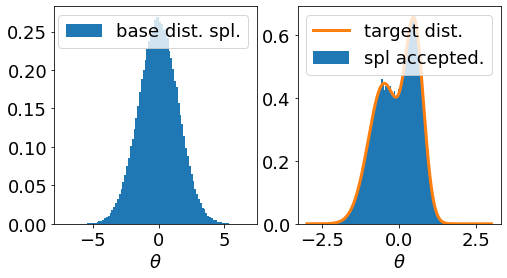

In [322]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].hist(base_spl, bins=100, density=True,label="base dist. spl.");
ax[0].legend();
ax[0].set_xlabel(r"$\theta$");
x=jnp.linspace(-3,3,1000)
ax[1].hist(spl_ok,bins=100, density=True,label="spl accepted.");
ax[1].plot(x,target_distribution.prob(x),label="target dist.",lw=3);
ax[1].legend();
ax[1].set_xlabel(r"$\theta$");


In [293]:
@partial(jax.jit, static_argnums=(1,))
def jax_metropolis_kernel(rng_key, logpdf, position, log_prob):
    key, subkey = jax.random.split(rng_key)
    """Moves the chain by one step using the Random Walk Metropolis algorithm.
  
    Attributes
    ----------
    rng_key: jax.random.PRNGKey
      Key for the pseudo random number generator.
    logpdf: function
      Returns the log-probability of the model given a position.
    position: np.ndarray, shape (n_dims,)
      The starting position.
    log_prob: float
      The log probability at the starting position.

    Returns
    -------
    Tuple
        The next positions of the chains along with their log probability.
    """
    move_proposals = jax.random.normal(key, shape=position.shape) * 0.1
    proposal = position + move_proposals
    proposal_log_prob = logpdf(proposal)

    log_uniform = jnp.log(jax.random.uniform(subkey))
    do_accept = log_uniform < proposal_log_prob - log_prob

    position = jnp.where(do_accept, proposal, position)
    log_prob = jnp.where(do_accept, proposal_log_prob, log_prob)
    return position, log_prob

@partial(jax.jit, static_argnums=(1, 2))
def jax_metropolis_sampler(rng_key, n_samples, logpdf, initial_position):
    """Generate samples using the Random Walk Metropolis algorithm.
    Attributes
    ----------
    rng_key: jax.random.PRNGKey
        Key for the pseudo random number generator.
    n_samples: int
        Number of samples to generate per chain.
    logpdf: function
      Returns the log-probability of the model given a position.
    inital_position: np.ndarray (n_dims, n_chains)
      The starting position.
    Returns
    -------
    (n_samples, n_dim)
    """
    def mh_update(i, state):
        key, positions, log_prob = state
        _, key = jax.random.split(key)
        new_position, new_log_prob = jax_metropolis_kernel(key, 
                                                           logpdf, 
                                                           positions[i-1], 
                                                           log_prob)
        positions=positions.at[i].set(new_position)
        return (key, positions, new_log_prob)


    logp = logpdf(initial_position)
    # all positions structure should be set before lax.fori_loop
    
    all_positions = jnp.zeros((n_samples,initial_position.shape[0]))  # 1 chain for each vmap call
    
    initial_state = (rng_key,all_positions, logp)
    rng_key, all_positions, log_prob = jax.lax.fori_loop(1, n_samples, 
                                                 mh_update, 
                                                 initial_state)
    
    
    return all_positions

In [312]:
n_dim = 1
n_forget = 25_000
n_samples = 100_000 + n_forget
n_chains = 3

rng_key = jax.random.PRNGKey(42)

rng_keys = jax.random.split(rng_key, n_chains)
initial_position = jnp.zeros((n_dim, n_chains))

run_mcmc = vmap(jax_metropolis_sampler, 
                    in_axes=(0, None, None, 1),
                    out_axes=0)
all_positions = run_mcmc(rng_keys, n_samples, 
                     lambda x: target_distribution.log_prob(x), 
                     initial_position)

all_positions = all_positions.squeeze()

all_positions=np.asarray(all_positions[:,n_forget:])

In [313]:
all_positions.shape

(3, 100000)

Text(0.5, 0.98, 'Metropolis-Hastings (Jax): 3 chains of 100000 spls')

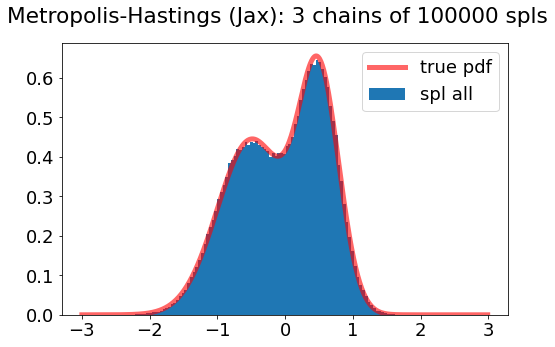

In [314]:
fig, axs = plt.subplots(1,1, figsize=(8,5))
axs.hist(all_positions.flatten(),bins=100, density=True,label=f"spl all");
x_axis = np.arange(-3, 3, 0.01)
axs.plot(x_axis, target_distribution.prob(x_axis),'r-', lw=5, alpha=0.6, label='true pdf')
axs.legend()
fig.suptitle(f"Metropolis-Hastings (Jax): {all_positions.shape[0]} chains of {all_positions.shape[1]} spls")
